# This is a tutorial of using spaVAE for the spatial imputation experiment of the human DLPFC section 151673 data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'sample_151673.h5'
        self.select_genes = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.noise = 1
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 2
        self.decoder_layers = [32]
        self.beta = 20
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.kernel_scale = 20.
        self.mask_prob = 0.2
        self.model_file = "model.pt"
        self.train_final_latent_file = "train_final_latent.txt"
        self.train_denoised_counts_file = "train_denoised_counts.txt"
        self.test_final_latent_file = "test_final_latent.txt"
        self.test_denoised_counts_file = "test_denoised_counts.txt"
        self.device = "cpu"

args = Args()

Setup inducing points, split training and testing sets, preprocess count matrix, and build the spaVAE model.

Then train the spaVAE model

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64')
loc = np.array(data_mat['pos']).astype('float64')
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * 20.

print(x.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * 20.
print(initial_inducing_points.shape)

sample_idx = np.arange(x.shape[0])
np.random.shuffle(sample_idx)
train_idx, test_idx = sample_idx[int(args.mask_prob*x.shape[0]):], sample_idx[:int(args.mask_prob*x.shape[0])]
np.savetxt(args.data_file[:-3]+"_train_index.txt", train_idx, delimiter=",", fmt="%i")
np.savetxt(args.data_file[:-3]+"_test_index.txt", test_idx, delimiter=",", fmt="%i")
x_train, x_test = x[train_idx], x[test_idx]
loc_train, loc_test = loc[train_idx], loc[test_idx]
print(x_train.shape, x_test.shape)
print(loc_train.shape, loc_test.shape)

adata_train = sc.AnnData(x_train, dtype="float64")

adata_train = normalize(adata_train,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata_train.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata_train.n_obs, beta=args.beta, dtype=torch.float64, 
    device=args.device)

print(str(model))

t0 = time()

model.train_model(pos=loc_train, ncounts=adata_train.X, raw_counts=adata_train.raw.X, size_factors=adata_train.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

final_latent = model.batching_latent_samples(X=loc_train, Y=adata_train.X, batch_size=args.batch_size)
np.savetxt(args.data_file[:-3]+"_"+args.train_final_latent_file, final_latent, delimiter=",")


denoised_counts = model.batching_denoise_counts(X=loc_train, Y=adata_train.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.data_file[:-3]+"_"+args.train_denoised_counts_file, denoised_counts, delimiter=",")

test_latent, test_denoised_counts = model.batching_predict_samples(X_test=loc_test, X_train=loc_train, Y_train=adata_train.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.data_file[:-3]+"_"+args.test_final_latent_file, test_latent, delimiter=",")
np.savetxt(args.data_file[:-3]+"_"+args.test_denoised_counts_file, test_denoised_counts, delimiter=",")


(3639, 3000)
(3639, 2)
(49, 2)
(2912, 3000) (727, 3000)
(2912, 2) (727, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=3000, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=2, bias=True)
    (enc_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, 

Training epoch 49, ELBO:20.60733081, NB loss:1.02703249, KLD loss:0.03018904, noise regularization:0.001825
Current kernel scale tensor([20.2202])
Training epoch 50, ELBO:20.60459508, NB loss:1.02686289, KLD loss:0.03049779, noise regularization:0.001842
Current kernel scale tensor([20.2238])
Training epoch 51, ELBO:20.55203829, NB loss:1.02418697, KLD loss:0.03067455, noise regularization:0.001881
Current kernel scale tensor([20.2274])
Training epoch 52, ELBO:20.48775100, NB loss:1.02107382, KLD loss:0.03079101, noise regularization:0.001774
Current kernel scale tensor([20.2309])
Training epoch 53, ELBO:20.52603176, NB loss:1.02273102, KLD loss:0.03054515, noise regularization:0.002043
Current kernel scale tensor([20.2342])
Training epoch 54, ELBO:20.44356782, NB loss:1.01935533, KLD loss:0.02968682, noise regularization:0.001339
Current kernel scale tensor([20.2375])
Training epoch 55, ELBO:20.46880691, NB loss:1.01990307, KLD loss:0.03026460, noise regularization:0.002024
Current ke

Training epoch 105, ELBO:19.94031601, NB loss:0.99437101, KLD loss:0.02767970, noise regularization:0.001261
Current kernel scale tensor([20.3686])
Training epoch 106, ELBO:19.82013908, NB loss:0.98861394, KLD loss:0.02702001, noise regularization:0.001042
Current kernel scale tensor([20.3708])
Training epoch 107, ELBO:19.90952446, NB loss:0.99327716, KLD loss:0.02649510, noise regularization:0.000874
Current kernel scale tensor([20.3729])
Training epoch 108, ELBO:19.87539261, NB loss:0.99161710, KLD loss:0.02692704, noise regularization:0.000806
Current kernel scale tensor([20.3751])
Training epoch 109, ELBO:19.94707283, NB loss:0.99510458, KLD loss:0.02668266, noise regularization:0.000915
Current kernel scale tensor([20.3772])
Training epoch 110, ELBO:19.91339030, NB loss:0.99323620, KLD loss:0.02655633, noise regularization:0.001106
Current kernel scale tensor([20.3793])
Training epoch 111, ELBO:19.83493976, NB loss:0.98940648, KLD loss:0.02674928, noise regularization:0.001003
Cur

Training epoch 161, ELBO:19.56927386, NB loss:0.97650994, KLD loss:0.02452770, noise regularization:0.000727
Current kernel scale tensor([20.4878])
Training epoch 162, ELBO:19.64092323, NB loss:0.97994090, KLD loss:0.02480338, noise regularization:0.000865
Current kernel scale tensor([20.4898])
Training epoch 163, ELBO:19.64404426, NB loss:0.98030699, KLD loss:0.02484760, noise regularization:0.000653
Current kernel scale tensor([20.4917])
Training epoch 164, ELBO:19.64690109, NB loss:0.98026883, KLD loss:0.02485828, noise regularization:0.000833
Current kernel scale tensor([20.4937])
Training epoch 165, ELBO:19.60442566, NB loss:0.97838088, KLD loss:0.02456247, noise regularization:0.000612
Current kernel scale tensor([20.4957])
Training epoch 166, ELBO:19.57472497, NB loss:0.97675555, KLD loss:0.02467788, noise regularization:0.000747
Current kernel scale tensor([20.4976])
Training epoch 167, ELBO:19.56876833, NB loss:0.97645296, KLD loss:0.02480381, noise regularization:0.000745
Cur

Training epoch 217, ELBO:19.45307692, NB loss:0.97106770, KLD loss:0.02180518, noise regularization:0.000496
Current kernel scale tensor([20.5950])
Training epoch 218, ELBO:19.44763018, NB loss:0.97043814, KLD loss:0.02232302, noise regularization:0.000827
Current kernel scale tensor([20.5969])
Training epoch 219, ELBO:19.46018589, NB loss:0.97127652, KLD loss:0.02209362, noise regularization:0.000628
Current kernel scale tensor([20.5988])
Training epoch 220, ELBO:19.48305979, NB loss:0.97247261, KLD loss:0.02246826, noise regularization:0.000557
Current kernel scale tensor([20.6007])
Training epoch 221, ELBO:19.41241907, NB loss:0.96887739, KLD loss:0.02245865, noise regularization:0.000621
Current kernel scale tensor([20.6025])
Training epoch 222, ELBO:19.43527166, NB loss:0.96999916, KLD loss:0.02263617, noise regularization:0.000633
Current kernel scale tensor([20.6043])
Training epoch 223, ELBO:19.45732208, NB loss:0.97113671, KLD loss:0.02280083, noise regularization:0.000589
Cur

Training epoch 273, ELBO:19.27853743, NB loss:0.96234196, KLD loss:0.02066020, noise regularization:0.000552
Current kernel scale tensor([20.6926])
Training epoch 274, ELBO:19.30012503, NB loss:0.96345905, KLD loss:0.02061995, noise regularization:0.000516
Current kernel scale tensor([20.6942])
Training epoch 275, ELBO:19.30056608, NB loss:0.96337564, KLD loss:0.02077657, noise regularization:0.000614
Current kernel scale tensor([20.6958])
Training epoch 276, ELBO:19.33163661, NB loss:0.96504352, KLD loss:0.02043476, noise regularization:0.000517
Current kernel scale tensor([20.6974])
Training epoch 277, ELBO:19.20654906, NB loss:0.95870639, KLD loss:0.02031328, noise regularization:0.000605
Current kernel scale tensor([20.6989])
Training epoch 278, ELBO:19.30321117, NB loss:0.96365148, KLD loss:0.01984103, noise regularization:0.000517
Current kernel scale tensor([20.7005])
Training epoch 279, ELBO:19.28073015, NB loss:0.96251226, KLD loss:0.01967234, noise regularization:0.000541
Cur

Training epoch 329, ELBO:19.20476772, NB loss:0.95853720, KLD loss:0.01711084, noise regularization:0.000846
Current kernel scale tensor([20.7927])
Training epoch 330, ELBO:19.18148078, NB loss:0.95760491, KLD loss:0.01717208, noise regularization:0.000611
Current kernel scale tensor([20.7946])
Training epoch 331, ELBO:19.14854494, NB loss:0.95584250, KLD loss:0.01690506, noise regularization:0.000739
Current kernel scale tensor([20.7966])
Training epoch 332, ELBO:19.05969000, NB loss:0.95157022, KLD loss:0.01694034, noise regularization:0.000567
Current kernel scale tensor([20.7986])
Training epoch 333, ELBO:19.18715560, NB loss:0.95791935, KLD loss:0.01706321, noise regularization:0.000585
Current kernel scale tensor([20.8006])
Training epoch 334, ELBO:19.09614933, NB loss:0.95329294, KLD loss:0.01713737, noise regularization:0.000658
Current kernel scale tensor([20.8026])
Training epoch 335, ELBO:19.18322548, NB loss:0.95763546, KLD loss:0.01708580, noise regularization:0.000672
Cur

Training epoch 385, ELBO:19.02477855, NB loss:0.94987056, KLD loss:0.01557842, noise regularization:0.000589
Current kernel scale tensor([20.9000])
Training epoch 386, ELBO:19.08839737, NB loss:0.95296075, KLD loss:0.01551948, noise regularization:0.000683
Current kernel scale tensor([20.9019])
Training epoch 387, ELBO:19.00770587, NB loss:0.94893664, KLD loss:0.01557223, noise regularization:0.000670
Current kernel scale tensor([20.9038])
Training epoch 388, ELBO:19.09819975, NB loss:0.95347563, KLD loss:0.01577328, noise regularization:0.000646
Current kernel scale tensor([20.9057])
Training epoch 389, ELBO:19.03540451, NB loss:0.95029679, KLD loss:0.01555705, noise regularization:0.000696
Current kernel scale tensor([20.9077])
Training epoch 390, ELBO:19.02284564, NB loss:0.94979740, KLD loss:0.01564334, noise regularization:0.000563
Current kernel scale tensor([20.9097])
Training epoch 391, ELBO:19.04099472, NB loss:0.95051442, KLD loss:0.01574543, noise regularization:0.000748
Cur

Training epoch 441, ELBO:18.90844957, NB loss:0.94414384, KLD loss:0.01540604, noise regularization:0.000508
Current kernel scale tensor([21.0098])
Training epoch 442, ELBO:18.90602050, NB loss:0.94399203, KLD loss:0.01552168, noise regularization:0.000533
Current kernel scale tensor([21.0118])
Training epoch 443, ELBO:18.94977529, NB loss:0.94604886, KLD loss:0.01566727, noise regularization:0.000657
Current kernel scale tensor([21.0138])
Training epoch 444, ELBO:18.93738441, NB loss:0.94538264, KLD loss:0.01522386, noise regularization:0.000725
Current kernel scale tensor([21.0158])
Training epoch 445, ELBO:18.95721412, NB loss:0.94643087, KLD loss:0.01512196, noise regularization:0.000674
Current kernel scale tensor([21.0178])
Training epoch 446, ELBO:18.92290871, NB loss:0.94487870, KLD loss:0.01524920, noise regularization:0.000504
Current kernel scale tensor([21.0199])
Training epoch 447, ELBO:18.95994669, NB loss:0.94666044, KLD loss:0.01534438, noise regularization:0.000570
Cur

Training epoch 497, ELBO:18.88238376, NB loss:0.94281904, KLD loss:0.01476454, noise regularization:0.000562
Current kernel scale tensor([21.1240])
Training epoch 498, ELBO:18.88001231, NB loss:0.94266482, KLD loss:0.01500844, noise regularization:0.000585
Current kernel scale tensor([21.1261])
Training epoch 499, ELBO:18.76661214, NB loss:0.93699083, KLD loss:0.01520156, noise regularization:0.000580
Current kernel scale tensor([21.1282])
Training epoch 500, ELBO:18.92102118, NB loss:0.94463922, KLD loss:0.01527493, noise regularization:0.000648
Current kernel scale tensor([21.1303])
Training epoch 501, ELBO:18.92762369, NB loss:0.94505283, KLD loss:0.01509208, noise regularization:0.000574
Current kernel scale tensor([21.1324])
Training epoch 502, ELBO:18.85653299, NB loss:0.94150009, KLD loss:0.01491661, noise regularization:0.000581
Current kernel scale tensor([21.1347])
Training epoch 503, ELBO:18.83655080, NB loss:0.94050773, KLD loss:0.01513373, noise regularization:0.000563
Cur

Training epoch 553, ELBO:18.81398488, NB loss:0.93932420, KLD loss:0.01523630, noise regularization:0.000613
Current kernel scale tensor([21.2491])
Training epoch 554, ELBO:18.82207621, NB loss:0.93971637, KLD loss:0.01524260, noise regularization:0.000625
Current kernel scale tensor([21.2514])
Training epoch 555, ELBO:18.85712572, NB loss:0.94159754, KLD loss:0.01507438, noise regularization:0.000505
Current kernel scale tensor([21.2537])
Training epoch 556, ELBO:18.79763715, NB loss:0.93859313, KLD loss:0.01503226, noise regularization:0.000537
Current kernel scale tensor([21.2560])
Training epoch 557, ELBO:18.84411985, NB loss:0.94097775, KLD loss:0.01509481, noise regularization:0.000473
Current kernel scale tensor([21.2584])
Training epoch 558, ELBO:18.88268278, NB loss:0.94277307, KLD loss:0.01535015, noise regularization:0.000594
Current kernel scale tensor([21.2607])
Training epoch 559, ELBO:18.86443096, NB loss:0.94184726, KLD loss:0.01525462, noise regularization:0.000612
Cur

Training epoch 609, ELBO:18.78619777, NB loss:0.93805081, KLD loss:0.01526036, noise regularization:0.000496
Current kernel scale tensor([21.3852])
Training epoch 610, ELBO:18.75792276, NB loss:0.93653794, KLD loss:0.01546558, noise regularization:0.000585
Current kernel scale tensor([21.3878])
Training epoch 611, ELBO:18.83080812, NB loss:0.94021804, KLD loss:0.01545663, noise regularization:0.000550
Current kernel scale tensor([21.3905])
Training epoch 612, ELBO:18.83218105, NB loss:0.94033648, KLD loss:0.01549998, noise regularization:0.000498
Current kernel scale tensor([21.3930])
Training epoch 613, ELBO:18.77111569, NB loss:0.93721197, KLD loss:0.01547270, noise regularization:0.000570
Current kernel scale tensor([21.3955])
Training epoch 614, ELBO:18.84659376, NB loss:0.94103067, KLD loss:0.01558382, noise regularization:0.000520
Current kernel scale tensor([21.3981])
Training epoch 615, ELBO:18.78383949, NB loss:0.93782922, KLD loss:0.01546270, noise regularization:0.000590
Cur

Training epoch 665, ELBO:18.75272188, NB loss:0.93633007, KLD loss:0.01521523, noise regularization:0.000545
Current kernel scale tensor([21.5351])
Training epoch 666, ELBO:18.79022941, NB loss:0.93824769, KLD loss:0.01543291, noise regularization:0.000492
Current kernel scale tensor([21.5378])
Training epoch 667, ELBO:18.78700419, NB loss:0.93804161, KLD loss:0.01578932, noise regularization:0.000519
Current kernel scale tensor([21.5405])
Training epoch 668, ELBO:18.79516868, NB loss:0.93837909, KLD loss:0.01595972, noise regularization:0.000581
Current kernel scale tensor([21.5432])
Training epoch 669, ELBO:18.74017305, NB loss:0.93567773, KLD loss:0.01556590, noise regularization:0.000553
Current kernel scale tensor([21.5459])
Training epoch 670, ELBO:18.78736141, NB loss:0.93804043, KLD loss:0.01540275, noise regularization:0.000557
Current kernel scale tensor([21.5487])
Training epoch 671, ELBO:18.76269778, NB loss:0.93676134, KLD loss:0.01516533, noise regularization:0.000615
Cur

Training epoch 721, ELBO:18.77135592, NB loss:0.93724800, KLD loss:0.01554601, noise regularization:0.000542
Current kernel scale tensor([21.6939])
Training epoch 722, ELBO:18.72509658, NB loss:0.93496507, KLD loss:0.01577000, noise regularization:0.000501
Current kernel scale tensor([21.6968])
Training epoch 723, ELBO:18.73324170, NB loss:0.93531734, KLD loss:0.01567822, noise regularization:0.000561
Current kernel scale tensor([21.6997])
Training epoch 724, ELBO:18.70596360, NB loss:0.93398802, KLD loss:0.01544557, noise regularization:0.000538
Current kernel scale tensor([21.7025])
Training epoch 725, ELBO:18.69211452, NB loss:0.93329446, KLD loss:0.01558062, noise regularization:0.000532
Current kernel scale tensor([21.7053])
Training epoch 726, ELBO:18.78814304, NB loss:0.93814048, KLD loss:0.01551491, noise regularization:0.000491
Current kernel scale tensor([21.7082])
Training epoch 727, ELBO:18.71274027, NB loss:0.93435791, KLD loss:0.01564575, noise regularization:0.000497
Cur

Training epoch 777, ELBO:18.73208581, NB loss:0.93528801, KLD loss:0.01551699, noise regularization:0.000540
Current kernel scale tensor([21.8612])
Training epoch 778, ELBO:18.76653265, NB loss:0.93704132, KLD loss:0.01537847, noise regularization:0.000516
Current kernel scale tensor([21.8644])
Training epoch 779, ELBO:18.70308748, NB loss:0.93391134, KLD loss:0.01554067, noise regularization:0.000466
Current kernel scale tensor([21.8676])
Training epoch 780, ELBO:18.71935031, NB loss:0.93465783, KLD loss:0.01586533, noise regularization:0.000516
Current kernel scale tensor([21.8707])
Training epoch 781, ELBO:18.72529396, NB loss:0.93490262, KLD loss:0.01607394, noise regularization:0.000558
Current kernel scale tensor([21.8737])
Training epoch 782, ELBO:18.71990021, NB loss:0.93458371, KLD loss:0.01597387, noise regularization:0.000613
Current kernel scale tensor([21.8767])
Training epoch 783, ELBO:18.67126673, NB loss:0.93219169, KLD loss:0.01588722, noise regularization:0.000577
Cur

Training epoch 833, ELBO:18.70858675, NB loss:0.93405876, KLD loss:0.01593373, noise regularization:0.000574
Current kernel scale tensor([22.0402])
Training epoch 834, ELBO:18.69022314, NB loss:0.93316224, KLD loss:0.01590780, noise regularization:0.000554
Current kernel scale tensor([22.0435])
Training epoch 835, ELBO:18.69813599, NB loss:0.93356094, KLD loss:0.01596738, noise regularization:0.000547
Current kernel scale tensor([22.0468])
Training epoch 836, ELBO:18.65460724, NB loss:0.93131003, KLD loss:0.01594073, noise regularization:0.000623
Current kernel scale tensor([22.0500])
Training epoch 837, ELBO:18.68246413, NB loss:0.93283829, KLD loss:0.01598174, noise regularization:0.000486
Current kernel scale tensor([22.0533])
Training epoch 838, ELBO:18.69671316, NB loss:0.93356742, KLD loss:0.01603453, noise regularization:0.000467
Current kernel scale tensor([22.0566])
Training epoch 839, ELBO:18.72940186, NB loss:0.93520010, KLD loss:0.01605449, noise regularization:0.000467
Cur

Training epoch 889, ELBO:18.66733568, NB loss:0.93201981, KLD loss:0.01586843, noise regularization:0.000554
Current kernel scale tensor([22.2229])
Training epoch 890, ELBO:18.72804106, NB loss:0.93504341, KLD loss:0.01575741, noise regularization:0.000571
Current kernel scale tensor([22.2263])
Training epoch 891, ELBO:18.69280598, NB loss:0.93324903, KLD loss:0.01613826, noise regularization:0.000584
Current kernel scale tensor([22.2296])
Training epoch 892, ELBO:18.62420126, NB loss:0.92979863, KLD loss:0.01644401, noise regularization:0.000589
Current kernel scale tensor([22.2329])
Training epoch 893, ELBO:18.70137243, NB loss:0.93375293, KLD loss:0.01628692, noise regularization:0.000501
Current kernel scale tensor([22.2361])
Training epoch 894, ELBO:18.70556207, NB loss:0.93396696, KLD loss:0.01585817, noise regularization:0.000518
Current kernel scale tensor([22.2394])
Training epoch 895, ELBO:18.66817778, NB loss:0.93217677, KLD loss:0.01588947, noise regularization:0.000438
Cur

Training epoch 945, ELBO:18.61654606, NB loss:0.92945066, KLD loss:0.01627498, noise regularization:0.000563
Current kernel scale tensor([22.4094])
Training epoch 946, ELBO:18.67762881, NB loss:0.93253967, KLD loss:0.01613682, noise regularization:0.000535
Current kernel scale tensor([22.4127])
Training epoch 947, ELBO:18.66429083, NB loss:0.93195415, KLD loss:0.01607054, noise regularization:0.000457
Current kernel scale tensor([22.4161])
Training epoch 948, ELBO:18.66696893, NB loss:0.93201006, KLD loss:0.01604656, noise regularization:0.000536
Current kernel scale tensor([22.4195])
Training epoch 949, ELBO:18.62756961, NB loss:0.92992184, KLD loss:0.01610707, noise regularization:0.000651
Current kernel scale tensor([22.4230])
Training epoch 950, ELBO:18.66676150, NB loss:0.93201938, KLD loss:0.01619860, noise regularization:0.000509
Current kernel scale tensor([22.4265])
Training epoch 951, ELBO:18.67089176, NB loss:0.93229631, KLD loss:0.01596214, noise regularization:0.000450
Cur

Training epoch 1001, ELBO:18.68138132, NB loss:0.93282708, KLD loss:0.01637223, noise regularization:0.000423
Current kernel scale tensor([22.6010])
Training epoch 1002, ELBO:18.63643395, NB loss:0.93055606, KLD loss:0.01638050, noise regularization:0.000447
Current kernel scale tensor([22.6045])
Training epoch 1003, ELBO:18.65179369, NB loss:0.93124813, KLD loss:0.01666788, noise regularization:0.000508
Current kernel scale tensor([22.6079])
Training epoch 1004, ELBO:18.64094938, NB loss:0.93061995, KLD loss:0.01682189, noise regularization:0.000586
Current kernel scale tensor([22.6112])
Training epoch 1005, ELBO:18.64783171, NB loss:0.93097679, KLD loss:0.01676125, noise regularization:0.000577
Current kernel scale tensor([22.6146])
Training epoch 1006, ELBO:18.61568583, NB loss:0.92939521, KLD loss:0.01654793, noise regularization:0.000562
Current kernel scale tensor([22.6179])
Training epoch 1007, ELBO:18.65443184, NB loss:0.93144362, KLD loss:0.01648413, noise regularization:0.000

Training epoch 1056, ELBO:18.64978408, NB loss:0.93113696, KLD loss:0.01661891, noise regularization:0.000521
Current kernel scale tensor([22.7944])
Training epoch 1057, ELBO:18.66087784, NB loss:0.93175366, KLD loss:0.01652817, noise regularization:0.000464
Current kernel scale tensor([22.7979])
Training epoch 1058, ELBO:18.59790981, NB loss:0.92854170, KLD loss:0.01667603, noise regularization:0.000520
Current kernel scale tensor([22.8013])
Training epoch 1059, ELBO:18.61114546, NB loss:0.92927788, KLD loss:0.01652868, noise regularization:0.000453
Current kernel scale tensor([22.8048])
Training epoch 1060, ELBO:18.62459349, NB loss:0.92982523, KLD loss:0.01659655, noise regularization:0.000575
Current kernel scale tensor([22.8083])
Training epoch 1061, ELBO:18.68359188, NB loss:0.93289291, KLD loss:0.01656272, noise regularization:0.000459
Current kernel scale tensor([22.8118])
Training epoch 1062, ELBO:18.61680135, NB loss:0.92946099, KLD loss:0.01654326, noise regularization:0.000

Training epoch 1111, ELBO:18.57723496, NB loss:0.92756914, KLD loss:0.01654567, noise regularization:0.000465
Current kernel scale tensor([22.9889])
Training epoch 1112, ELBO:18.67835078, NB loss:0.93265027, KLD loss:0.01629447, noise regularization:0.000453
Current kernel scale tensor([22.9925])
Training epoch 1113, ELBO:18.57074245, NB loss:0.92724195, KLD loss:0.01627912, noise regularization:0.000481
Current kernel scale tensor([22.9961])
Training epoch 1114, ELBO:18.61174187, NB loss:0.92918345, KLD loss:0.01664168, noise regularization:0.000572
Current kernel scale tensor([22.9997])
Training epoch 1115, ELBO:18.64838807, NB loss:0.93105029, KLD loss:0.01666930, noise regularization:0.000536
Current kernel scale tensor([23.0034])
Training epoch 1116, ELBO:18.65443241, NB loss:0.93129189, KLD loss:0.01673611, noise regularization:0.000593
Current kernel scale tensor([23.0070])
Training epoch 1117, ELBO:18.58895505, NB loss:0.92808068, KLD loss:0.01659685, noise regularization:0.000

Training epoch 1166, ELBO:18.59825486, NB loss:0.92847717, KLD loss:0.01699866, noise regularization:0.000586
Current kernel scale tensor([23.1858])
Training epoch 1167, ELBO:18.66036533, NB loss:0.93165885, KLD loss:0.01701708, noise regularization:0.000509
Current kernel scale tensor([23.1894])
Training epoch 1168, ELBO:18.70346651, NB loss:0.93386385, KLD loss:0.01682784, noise regularization:0.000468
Current kernel scale tensor([23.1929])
Training epoch 1169, ELBO:18.64857923, NB loss:0.93107415, KLD loss:0.01680713, noise regularization:0.000514
Current kernel scale tensor([23.1965])
Training epoch 1170, ELBO:18.62139432, NB loss:0.92972079, KLD loss:0.01676133, noise regularization:0.000511
Current kernel scale tensor([23.2002])
Training epoch 1171, ELBO:18.60352238, NB loss:0.92873802, KLD loss:0.01677875, noise regularization:0.000599
Current kernel scale tensor([23.2038])
Training epoch 1172, ELBO:18.60033895, NB loss:0.92865320, KLD loss:0.01642733, noise regularization:0.000

Training epoch 1221, ELBO:18.61584687, NB loss:0.92945110, KLD loss:0.01726477, noise regularization:0.000478
Current kernel scale tensor([23.3821])
Training epoch 1222, ELBO:18.59908868, NB loss:0.92856856, KLD loss:0.01725483, noise regularization:0.000523
Current kernel scale tensor([23.3856])
Training epoch 1223, ELBO:18.67374111, NB loss:0.93234234, KLD loss:0.01713344, noise regularization:0.000488
Current kernel scale tensor([23.3891])
Training epoch 1224, ELBO:18.58927308, NB loss:0.92809332, KLD loss:0.01715630, noise regularization:0.000513
Current kernel scale tensor([23.3927])
Training epoch 1225, ELBO:18.57531284, NB loss:0.92746532, KLD loss:0.01698010, noise regularization:0.000451
Current kernel scale tensor([23.3963])
Training epoch 1226, ELBO:18.58069375, NB loss:0.92761581, KLD loss:0.01701631, noise regularization:0.000568
Current kernel scale tensor([23.3999])
Training epoch 1227, ELBO:18.56056098, NB loss:0.92661077, KLD loss:0.01697017, noise regularization:0.000

Training epoch 1276, ELBO:18.59051050, NB loss:0.92815593, KLD loss:0.01742639, noise regularization:0.000498
Current kernel scale tensor([23.5832])
Training epoch 1277, ELBO:18.61441087, NB loss:0.92937649, KLD loss:0.01721067, noise regularization:0.000484
Current kernel scale tensor([23.5869])
Training epoch 1278, ELBO:18.55114382, NB loss:0.92618084, KLD loss:0.01717632, noise regularization:0.000518
Current kernel scale tensor([23.5906])
Training epoch 1279, ELBO:18.57530038, NB loss:0.92742947, KLD loss:0.01734937, noise regularization:0.000468
Current kernel scale tensor([23.5942])
Training epoch 1280, ELBO:18.66831653, NB loss:0.93210658, KLD loss:0.01722279, noise regularization:0.000448
Current kernel scale tensor([23.5979])
Training epoch 1281, ELBO:18.64994416, NB loss:0.93116055, KLD loss:0.01720559, noise regularization:0.000476
Current kernel scale tensor([23.6016])
Training epoch 1282, ELBO:18.59931593, NB loss:0.92861593, KLD loss:0.01747355, noise regularization:0.000

Training epoch 1331, ELBO:18.55986386, NB loss:0.92652699, KLD loss:0.01750007, noise regularization:0.000591
Current kernel scale tensor([23.7803])
Training epoch 1332, ELBO:18.60727377, NB loss:0.92899989, KLD loss:0.01740714, noise regularization:0.000493
Current kernel scale tensor([23.7839])
Training epoch 1333, ELBO:18.59088656, NB loss:0.92815656, KLD loss:0.01737955, noise regularization:0.000519
Current kernel scale tensor([23.7874])
Training epoch 1334, ELBO:18.64178270, NB loss:0.93080752, KLD loss:0.01707321, noise regularization:0.000428
Current kernel scale tensor([23.7909])
Training epoch 1335, ELBO:18.57264423, NB loss:0.92730137, KLD loss:0.01714185, noise regularization:0.000474
Current kernel scale tensor([23.7944])
Training epoch 1336, ELBO:18.62186447, NB loss:0.92970186, KLD loss:0.01708232, noise regularization:0.000537
Current kernel scale tensor([23.7981])
Training epoch 1337, ELBO:18.60146626, NB loss:0.92878205, KLD loss:0.01736895, noise regularization:0.000

Training epoch 1386, ELBO:18.62794544, NB loss:0.93001446, KLD loss:0.01763655, noise regularization:0.000501
Current kernel scale tensor([23.9804])
Training epoch 1387, ELBO:18.60060557, NB loss:0.92867884, KLD loss:0.01765326, noise regularization:0.000469
Current kernel scale tensor([23.9841])
Training epoch 1388, ELBO:18.58643827, NB loss:0.92800507, KLD loss:0.01745233, noise regularization:0.000444
Current kernel scale tensor([23.9877])
Training epoch 1389, ELBO:18.58794150, NB loss:0.92799946, KLD loss:0.01764155, noise regularization:0.000516
Current kernel scale tensor([23.9914])
Training epoch 1390, ELBO:18.56683494, NB loss:0.92697304, KLD loss:0.01758699, noise regularization:0.000489
Current kernel scale tensor([23.9951])
Training epoch 1391, ELBO:18.55419040, NB loss:0.92625893, KLD loss:0.01771832, noise regularization:0.000565
Current kernel scale tensor([23.9987])
Training epoch 1392, ELBO:18.65025472, NB loss:0.93110404, KLD loss:0.01726319, noise regularization:0.000

Training epoch 1441, ELBO:18.55515149, NB loss:0.92638063, KLD loss:0.01743006, noise regularization:0.000505
Current kernel scale tensor([24.1810])
Training epoch 1442, ELBO:18.57424575, NB loss:0.92737691, KLD loss:0.01750729, noise regularization:0.000460
Current kernel scale tensor([24.1845])
Training epoch 1443, ELBO:18.59465287, NB loss:0.92824282, KLD loss:0.01779441, noise regularization:0.000600
Current kernel scale tensor([24.1879])
Training epoch 1444, ELBO:18.59629429, NB loss:0.92845139, KLD loss:0.01779013, noise regularization:0.000474
Current kernel scale tensor([24.1914])
Training epoch 1445, ELBO:18.59536936, NB loss:0.92843164, KLD loss:0.01769797, noise regularization:0.000452
Current kernel scale tensor([24.1950])
Training epoch 1446, ELBO:18.61028125, NB loss:0.92919723, KLD loss:0.01767817, noise regularization:0.000433
Current kernel scale tensor([24.1986])
Training epoch 1447, ELBO:18.56658011, NB loss:0.92692139, KLD loss:0.01780227, noise regularization:0.000

Training epoch 1496, ELBO:18.52019312, NB loss:0.92464137, KLD loss:0.01804832, noise regularization:0.000466
Current kernel scale tensor([24.3833])
Training epoch 1497, ELBO:18.61323334, NB loss:0.92923811, KLD loss:0.01819433, noise regularization:0.000514
Current kernel scale tensor([24.3870])
Training epoch 1498, ELBO:18.55945952, NB loss:0.92662370, KLD loss:0.01828057, noise regularization:0.000435
Current kernel scale tensor([24.3906])
Training epoch 1499, ELBO:18.60941020, NB loss:0.92905805, KLD loss:0.01800861, noise regularization:0.000512
Current kernel scale tensor([24.3941])
Training epoch 1500, ELBO:18.57107109, NB loss:0.92722509, KLD loss:0.01779668, noise regularization:0.000439
Current kernel scale tensor([24.3977])
Training epoch 1501, ELBO:18.60848107, NB loss:0.92902024, KLD loss:0.01781609, noise regularization:0.000513
Current kernel scale tensor([24.4012])
Training epoch 1502, ELBO:18.58565591, NB loss:0.92788625, KLD loss:0.01786210, noise regularization:0.000

Training epoch 1551, ELBO:18.54605358, NB loss:0.92595680, KLD loss:0.01799009, noise regularization:0.000446
Current kernel scale tensor([24.5838])
Training epoch 1552, ELBO:18.60922348, NB loss:0.92905472, KLD loss:0.01769584, noise regularization:0.000522
Current kernel scale tensor([24.5873])
Training epoch 1553, ELBO:18.59641583, NB loss:0.92851540, KLD loss:0.01771830, noise regularization:0.000419
Current kernel scale tensor([24.5907])
Training epoch 1554, ELBO:18.55496348, NB loss:0.92635349, KLD loss:0.01757451, noise regularization:0.000516
Current kernel scale tensor([24.5942])
Training epoch 1555, ELBO:18.58055990, NB loss:0.92772011, KLD loss:0.01777058, noise regularization:0.000419
Current kernel scale tensor([24.5978])
Training epoch 1556, ELBO:18.55611466, NB loss:0.92636426, KLD loss:0.01812020, noise regularization:0.000535
Current kernel scale tensor([24.6013])
Training epoch 1557, ELBO:18.57944029, NB loss:0.92762339, KLD loss:0.01826320, noise regularization:0.000

Training epoch 1606, ELBO:18.56538012, NB loss:0.92689112, KLD loss:0.01795587, noise regularization:0.000480
Current kernel scale tensor([24.7824])
Training epoch 1607, ELBO:18.61303474, NB loss:0.92928987, KLD loss:0.01800287, noise regularization:0.000462
Current kernel scale tensor([24.7861])
Training epoch 1608, ELBO:18.60671243, NB loss:0.92895194, KLD loss:0.01789573, noise regularization:0.000489
Current kernel scale tensor([24.7897])
Training epoch 1609, ELBO:18.65403707, NB loss:0.93124904, KLD loss:0.01837701, noise regularization:0.000534
Current kernel scale tensor([24.7934])
Training epoch 1610, ELBO:18.63815581, NB loss:0.93044312, KLD loss:0.01812355, noise regularization:0.000558
Current kernel scale tensor([24.7969])
Training epoch 1611, ELBO:18.58225742, NB loss:0.92771245, KLD loss:0.01812769, noise regularization:0.000494
Current kernel scale tensor([24.8005])
Training epoch 1612, ELBO:18.54338598, NB loss:0.92583291, KLD loss:0.01808336, noise regularization:0.000

Training epoch 1661, ELBO:18.55541883, NB loss:0.92633063, KLD loss:0.01839796, noise regularization:0.000520
Current kernel scale tensor([24.9790])
Training epoch 1662, ELBO:18.54923556, NB loss:0.92601680, KLD loss:0.01863657, noise regularization:0.000513
Current kernel scale tensor([24.9827])
Training epoch 1663, ELBO:18.54791757, NB loss:0.92603689, KLD loss:0.01831117, noise regularization:0.000443
Current kernel scale tensor([24.9862])
Training epoch 1664, ELBO:18.62753031, NB loss:0.92999031, KLD loss:0.01826667, noise regularization:0.000473
Current kernel scale tensor([24.9898])
Training epoch 1665, ELBO:18.62706395, NB loss:0.92988065, KLD loss:0.01828110, noise regularization:0.000558
Current kernel scale tensor([24.9934])
Training epoch 1666, ELBO:18.61888886, NB loss:0.92957414, KLD loss:0.01801239, noise regularization:0.000470
Current kernel scale tensor([24.9971])
Training epoch 1667, ELBO:18.51739618, NB loss:0.92437785, KLD loss:0.01815999, noise regularization:0.000

Training epoch 1716, ELBO:18.57798241, NB loss:0.92755659, KLD loss:0.01836969, noise regularization:0.000424
Current kernel scale tensor([25.1777])
Training epoch 1717, ELBO:18.63276632, NB loss:0.93027861, KLD loss:0.01876051, noise regularization:0.000422
Current kernel scale tensor([25.1813])
Training epoch 1718, ELBO:18.60254740, NB loss:0.92863603, KLD loss:0.01873672, noise regularization:0.000555
Current kernel scale tensor([25.1850])
Training epoch 1719, ELBO:18.60897377, NB loss:0.92910309, KLD loss:0.01884165, noise regularization:0.000404
Current kernel scale tensor([25.1888])
Training epoch 1720, ELBO:18.61325679, NB loss:0.92924146, KLD loss:0.01879037, noise regularization:0.000482
Current kernel scale tensor([25.1924])
Training epoch 1721, ELBO:18.56021506, NB loss:0.92661728, KLD loss:0.01862536, noise regularization:0.000462
Current kernel scale tensor([25.1958])
Training epoch 1722, ELBO:18.55877971, NB loss:0.92651506, KLD loss:0.01856777, noise regularization:0.000

Training epoch 1771, ELBO:18.58726897, NB loss:0.92795774, KLD loss:0.01862996, noise regularization:0.000474
Current kernel scale tensor([25.3741])
Training epoch 1772, ELBO:18.52071575, NB loss:0.92469211, KLD loss:0.01833818, noise regularization:0.000427
Current kernel scale tensor([25.3775])
Training epoch 1773, ELBO:18.56738430, NB loss:0.92704021, KLD loss:0.01817857, noise regularization:0.000420
Current kernel scale tensor([25.3809])
Training epoch 1774, ELBO:18.60265795, NB loss:0.92878623, KLD loss:0.01829170, noise regularization:0.000432
Current kernel scale tensor([25.3845])
Training epoch 1775, ELBO:18.55200642, NB loss:0.92622009, KLD loss:0.01836641, noise regularization:0.000462
Current kernel scale tensor([25.3881])
Training epoch 1776, ELBO:18.59092531, NB loss:0.92817548, KLD loss:0.01865440, noise regularization:0.000438
Current kernel scale tensor([25.3915])
Training epoch 1777, ELBO:18.62572210, NB loss:0.92983601, KLD loss:0.01832711, noise regularization:0.000

Training epoch 1826, ELBO:18.58759917, NB loss:0.92801710, KLD loss:0.01855499, noise regularization:0.000435
Current kernel scale tensor([25.5679])
Training epoch 1827, ELBO:18.58674319, NB loss:0.92798009, KLD loss:0.01836359, noise regularization:0.000439
Current kernel scale tensor([25.5714])
Training epoch 1828, ELBO:18.61464594, NB loss:0.92936729, KLD loss:0.01841640, noise regularization:0.000444
Current kernel scale tensor([25.5750])
Training epoch 1829, ELBO:18.52540624, NB loss:0.92493951, KLD loss:0.01872295, noise regularization:0.000395
Current kernel scale tensor([25.5786])
Training epoch 1830, ELBO:18.61030304, NB loss:0.92916145, KLD loss:0.01887613, noise regularization:0.000410
Current kernel scale tensor([25.5821])
Training epoch 1831, ELBO:18.55808367, NB loss:0.92655175, KLD loss:0.01884168, noise regularization:0.000410
Current kernel scale tensor([25.5855])
Training epoch 1832, ELBO:18.57934529, NB loss:0.92746837, KLD loss:0.01876556, noise regularization:0.000

Training epoch 1881, ELBO:18.54289368, NB loss:0.92576967, KLD loss:0.01900390, noise regularization:0.000425
Current kernel scale tensor([25.7635])
Training epoch 1882, ELBO:18.60652310, NB loss:0.92898482, KLD loss:0.01907705, noise regularization:0.000387
Current kernel scale tensor([25.7669])
Training epoch 1883, ELBO:18.51088937, NB loss:0.92419806, KLD loss:0.01909862, noise regularization:0.000391
Current kernel scale tensor([25.7702])
Training epoch 1884, ELBO:18.54850037, NB loss:0.92601262, KLD loss:0.01907500, noise regularization:0.000459
Current kernel scale tensor([25.7736])
Training epoch 1885, ELBO:18.55321008, NB loss:0.92618874, KLD loss:0.01867988, noise regularization:0.000538
Current kernel scale tensor([25.7770])
Training epoch 1886, ELBO:18.66275092, NB loss:0.93172142, KLD loss:0.01864122, noise regularization:0.000484
Current kernel scale tensor([25.7803])
Training epoch 1887, ELBO:18.58443160, NB loss:0.92787168, KLD loss:0.01866782, noise regularization:0.000

Training epoch 1936, ELBO:18.56595733, NB loss:0.92687663, KLD loss:0.01870653, noise regularization:0.000486
Current kernel scale tensor([25.9549])
Training epoch 1937, ELBO:18.55191405, NB loss:0.92625211, KLD loss:0.01855613, noise regularization:0.000416
Current kernel scale tensor([25.9584])
Training epoch 1938, ELBO:18.55616743, NB loss:0.92639422, KLD loss:0.01873814, noise regularization:0.000477
Current kernel scale tensor([25.9619])
Training epoch 1939, ELBO:18.58460948, NB loss:0.92782840, KLD loss:0.01848007, noise regularization:0.000478
Current kernel scale tensor([25.9654])
Training epoch 1940, ELBO:18.62348661, NB loss:0.92975748, KLD loss:0.01847390, noise regularization:0.000493
Current kernel scale tensor([25.9689])
Training epoch 1941, ELBO:18.53623414, NB loss:0.92543067, KLD loss:0.01868427, noise regularization:0.000447
Current kernel scale tensor([25.9724])
Training epoch 1942, ELBO:18.56697016, NB loss:0.92698238, KLD loss:0.01873157, noise regularization:0.000

Training epoch 1991, ELBO:18.59465339, NB loss:0.92839412, KLD loss:0.01861974, noise regularization:0.000408
Current kernel scale tensor([26.1463])
Training epoch 1992, ELBO:18.52348739, NB loss:0.92482339, KLD loss:0.01904250, noise regularization:0.000399
Current kernel scale tensor([26.1498])
Training epoch 1993, ELBO:18.54341524, NB loss:0.92573315, KLD loss:0.01905313, noise regularization:0.000485
Current kernel scale tensor([26.1533])
Training epoch 1994, ELBO:18.59364676, NB loss:0.92820661, KLD loss:0.01908653, noise regularization:0.000521
Current kernel scale tensor([26.1569])
Training epoch 1995, ELBO:18.59835082, NB loss:0.92846865, KLD loss:0.01903540, noise regularization:0.000497
Current kernel scale tensor([26.1603])
Training epoch 1996, ELBO:18.55519414, NB loss:0.92629469, KLD loss:0.01902279, noise regularization:0.000514
Current kernel scale tensor([26.1638])
Training epoch 1997, ELBO:18.54928685, NB loss:0.92605524, KLD loss:0.01873895, noise regularization:0.000

Plot results in R and ggplot2.

Using 11-nearest neighbors predictor to predict labels of testing set.

In [1]:
rm(list=ls())
library(class)
library(rhdf5)
library(ggplot2)
library(scater)

train.embedding <- read.table("sample_151673_train_final_latent.txt", sep=",")
train.idx <- as.numeric(readLines("sample_151673_train_index.txt"))+1
test.embedding <- read.table("sample_151673_test_final_latent.txt", sep=",")
test.idx <- as.numeric(readLines("sample_151673_test_index.txt"))+1

Y <- h5read("sample_151673.h5", "Y")
na.idx <- which(is.na(Y))

no.na.train.idx <- ! (train.idx %in% na.idx)
no.na.test.idx <- ! (test.idx %in% na.idx)

test.knn <- knn(train.embedding[no.na.train.idx,], test.embedding[no.na.test.idx,], Y[train.idx[no.na.train.idx]], k=11)
test.acc <- mean(test.knn == Y[test.idx[no.na.test.idx]])

print("Testing 11-NN accurarcy")
print(test.acc)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

[1] "Testing 11-NN accurarcy"
[1] 0.9362881


Plot the spaVAE latent embedding of training and testing sets.

Warning message:
“Using alpha for a discrete variable is not advised.”


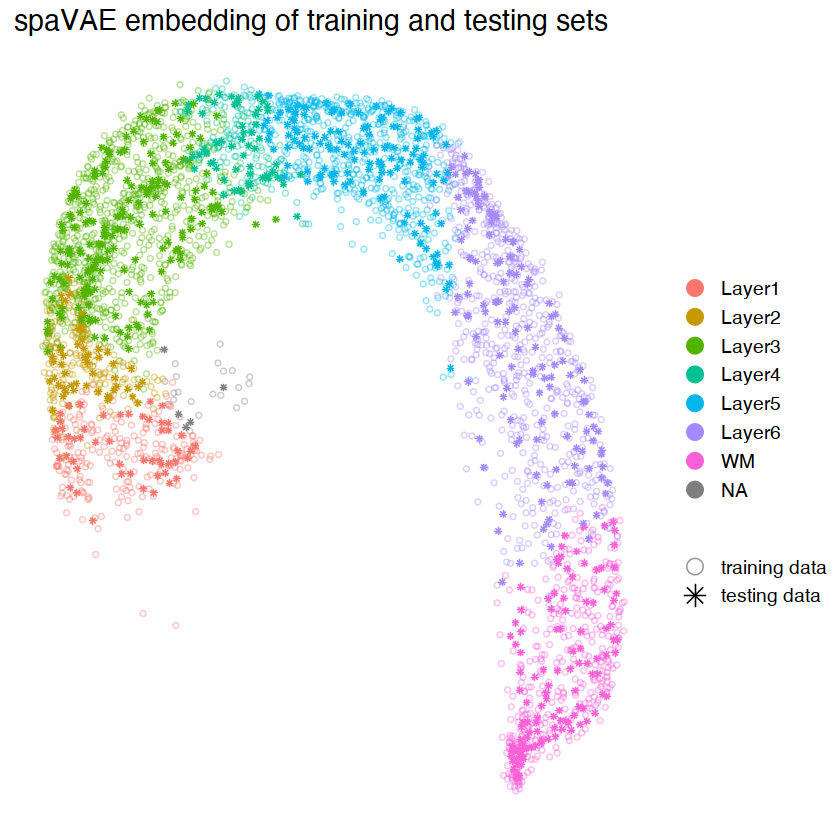

In [2]:
dat <- data.frame(rbind(train.embedding, test.embedding), Y=c(Y[train.idx], Y[test.idx]),
                    data=c(rep("training data", nrow(train.embedding)), rep("testing data", nrow(test.embedding))))
dat$data <- factor(dat$data, levels=c("training data", "testing data"))

ggplot(dat, aes(x=V1, y=V2, color=Y, shape=data, alpha=data)) + geom_point(size=1) + 
ggtitle("spaVAE embedding of training and testing sets") +
scale_shape_manual(values=c(1, 8)) + scale_alpha_discrete(range=c("training data"=0.4, "testing data"=1)) + theme_classic() + 
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank(), text = element_text(size=14)) +
guides(colour = guide_legend(override.aes = list(size=4)), shape = guide_legend(override.aes = list(size=4)))

Plot spaVAE imputed counts of marker genes.

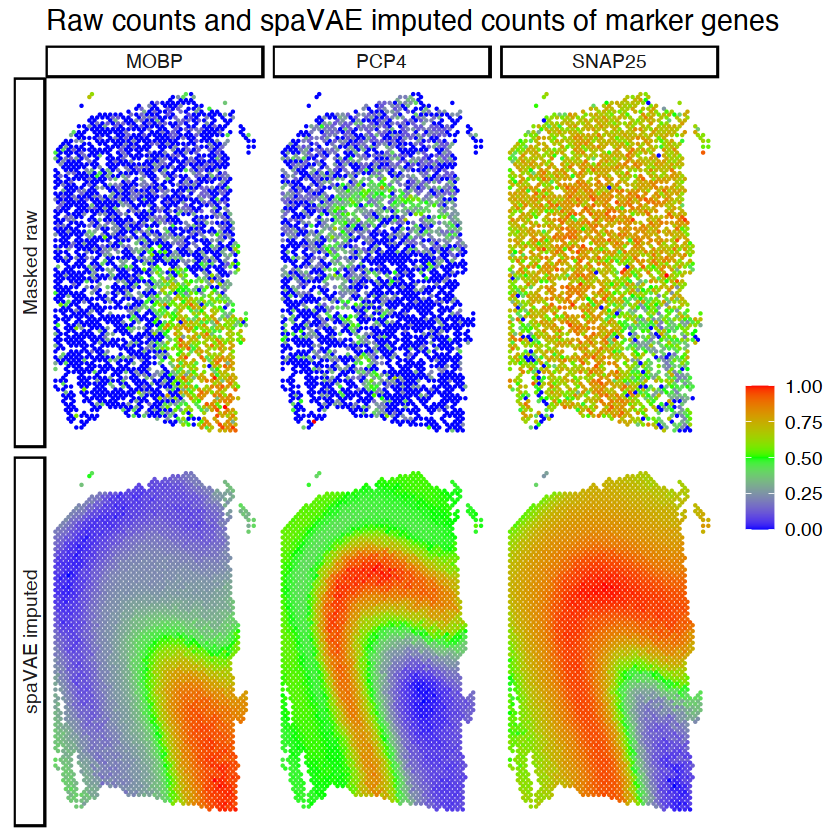

In [3]:
pos <- t(h5read("sample_151673.h5", "pos"))
pos <- data.frame(pos)
colnames(pos) <- c("x", "y")
raw.counts <- h5read("sample_151673.h5", "X")
gene <- h5read("sample_151673.h5", "gene")
cell <- h5read("sample_151673.h5", "cell")
rownames(pos) <- cell

sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- gene
colnames(sce) <- cell
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- t(apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1))))

                        
train_counts <- read.table("sample_151673_train_denoised_counts.txt", sep=",")
train_idx <- as.numeric(readLines("sample_151673_train_index.txt"))+1
rownames(train_counts) <- train_idx
colnames(train_counts) <- gene

logtraincounts <- log(train_counts)
logtraincounts <- t(apply(logtraincounts, 2, function(z) scales::rescale(z, to=c(0,1))))

test_counts <- read.table("sample_151673_test_denoised_counts.txt", sep=",")
test_idx <- as.numeric(readLines("sample_151673_test_index.txt"))+1
rownames(test_counts) <- test_idx
colnames(test_counts) <- gene

combine_counts <- rbind(train_counts, test_counts)
colnames(combine_counts) <- gene

logcombinecounts <- log(combine_counts)
logcombinecounts <- t(apply(logcombinecounts, 2, function(z) scales::rescale(z, to=c(0,1))))

combine_idx <- c(train_idx, test_idx)

impute.raw.dat <- data.frame(exp=c(lograwcounts["ENSG00000168314",train_idx], lograwcounts["ENSG00000183036",train_idx],
                                 lograwcounts["ENSG00000132639",train_idx]),
                           gene=rep(c("MOBP", "PCP4", "SNAP25"), each=ncol(lograwcounts[,train_idx])),
                           x=rep(pos[train_idx, "x"], 3), y=rep(pos[train_idx, "y"], 3), data="Masked raw")
impute.combine.dat <- data.frame(exp=c(logcombinecounts["ENSG00000168314",], logcombinecounts["ENSG00000183036",],
                                     logcombinecounts["ENSG00000132639",]),
                               gene=rep(c("MOBP", "PCP4", "SNAP25"), each=ncol(logcombinecounts)),
                               x=rep(pos[combine_idx, "x"], 3), y=rep(pos[combine_idx, "y"], 3), data="spaVAE imputed")
impute.dat <- rbind(impute.raw.dat, impute.combine.dat)
impute.dat$gene <- factor(impute.dat$gene, levels=c("MOBP", "PCP4", "SNAP25"))

ggplot(impute.dat, aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
facet_grid(data~gene, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
ggtitle("Raw counts and spaVAE imputed counts of marker genes") + theme_classic() + 
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank(), text = element_text(size=14))